# imports

In [2]:
import classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import shutil
import os
import time
import copy
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import random
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import pandas as pd
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve, precision_score, recall_score, accuracy_score
import seaborn as sns

cuda


# General

In [3]:
PROJECT_PATH = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# specifics

In [4]:
batch_size = 128
betas = (0.99, 0.999)
num_epochs = 50
step_size =  7
gamma = 0.1
model_name = 'resnet18'
retrain = False
load_model = os.path.join(PROJECT_PATH, 'models', 'resnet18', 'resnet18.pth')
add_classes_dir = os.path.join(PROJECT_PATH, 'add_classes')

#after adding classes
learning_rate_first_layers =0.001
learning_rate_final_layer = 0.01
eveluate = True

# datasets and loaders

## prepare labels

In [5]:
DATA_DIR_PATH = os.path.join(PROJECT_PATH, 'dataset')

## datasets

In [6]:
# Define data transformations including data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create the custom dataset
dataset = classifier.CustomDataset(DATA_DIR_PATH, transform=transform)

# Split the dataset into train, validation, and test subsets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
ds = {'train': train_data, 'valid': val_data, 'test': test_data}

## data loaders

In [8]:
# Create data loaders for each split
dataloaders = {key: DataLoader(ds[key], batch_size=batch_size, shuffle=True) for key in ds.keys()} 
dataset_sizes = {
    'train': len(train_data),
    'valid': len(val_data)
}

# Model

## chose model

In [9]:
model_name

'resnet18'

In [10]:
num_classes = None
model_state_dict = None
class_labels = None

if load_model:
        checkpoint = torch.load(load_model)
        model_name = checkpoint['model_name']
        num_classes = checkpoint['num_classes']
        model_state_dict = checkpoint['state_dict']
        class_labels = checkpoint['class_labels']
        print(f'{num_classes=}')
elif DATA_DIR_PATH:
    num_classes = len(dataset.main_classes_set.keys())
else:
    print("Please provide a data directory or a model to load")

model_ft = classifier.create_model_instance(model_name, num_classes) 
if load_model:
    print(f'{num_classes=}')
    model_ft.load_state_dict(model_state_dict)

# Transfer the model to GPU
model_ft = model_ft.to(device)
    

num_classes=16
Creating resnet18
#######################type(model)=<class 'torchvision.models.resnet.ResNet'>
num_classes=16


/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## params

In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer_ft = optim.AdamW(model_ft.parameters(), betas=betas)
# Learning rate decay
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

# Train

## fit/train

Epoch 0/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


train Loss: 0.0051 Acc: 0.7907


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


valid Loss: 0.0056 Acc: 0.7933

Epoch 1/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0025 Acc: 0.8964


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


valid Loss: 0.0055 Acc: 0.8210

Epoch 2/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


train Loss: 0.0020 Acc: 0.9121


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


valid Loss: 0.0035 Acc: 0.8743

Epoch 3/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0018 Acc: 0.9254


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


valid Loss: 0.0052 Acc: 0.8352

Epoch 4/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


train Loss: 0.0016 Acc: 0.9276


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


valid Loss: 0.0023 Acc: 0.9124

Epoch 5/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


train Loss: 0.0011 Acc: 0.9492


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0016 Acc: 0.9400

Epoch 6/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.29s/it]


train Loss: 0.0010 Acc: 0.9537


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


valid Loss: 0.0022 Acc: 0.9257

Epoch 7/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


train Loss: 0.0009 Acc: 0.9610


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


valid Loss: 0.0012 Acc: 0.9543

Epoch 8/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


train Loss: 0.0007 Acc: 0.9739


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


valid Loss: 0.0013 Acc: 0.9543

Epoch 9/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


train Loss: 0.0006 Acc: 0.9761


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0009 Acc: 0.9610

Epoch 10/49
----------


100%|██████████| 39/39 [00:48<00:00,  1.25s/it]


train Loss: 0.0005 Acc: 0.9810


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


valid Loss: 0.0009 Acc: 0.9676

Epoch 11/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.30s/it]


train Loss: 0.0004 Acc: 0.9837


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


valid Loss: 0.0011 Acc: 0.9629

Epoch 12/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


train Loss: 0.0004 Acc: 0.9855


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


valid Loss: 0.0008 Acc: 0.9676

Epoch 13/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.28s/it]


train Loss: 0.0003 Acc: 0.9869


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0010 Acc: 0.9714

Epoch 14/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


train Loss: 0.0003 Acc: 0.9882


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0008 Acc: 0.9657

Epoch 15/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.28s/it]


train Loss: 0.0003 Acc: 0.9878


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


valid Loss: 0.0008 Acc: 0.9743

Epoch 16/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.29s/it]


train Loss: 0.0003 Acc: 0.9876


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


valid Loss: 0.0007 Acc: 0.9733

Epoch 17/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


train Loss: 0.0003 Acc: 0.9886


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


valid Loss: 0.0007 Acc: 0.9714

Epoch 18/49
----------


100%|██████████| 39/39 [00:48<00:00,  1.24s/it]


train Loss: 0.0003 Acc: 0.9894


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


valid Loss: 0.0007 Acc: 0.9695

Epoch 19/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.28s/it]


train Loss: 0.0003 Acc: 0.9910


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


valid Loss: 0.0007 Acc: 0.9695

Epoch 20/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.30s/it]


train Loss: 0.0003 Acc: 0.9892


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0009 Acc: 0.9724

Epoch 21/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.28s/it]


train Loss: 0.0003 Acc: 0.9906


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0006 Acc: 0.9790

Epoch 22/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.26s/it]


train Loss: 0.0003 Acc: 0.9912


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0007 Acc: 0.9695

Epoch 23/49
----------


100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


train Loss: 0.0003 Acc: 0.9900


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0009 Acc: 0.9648

Epoch 24/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


train Loss: 0.0003 Acc: 0.9882


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


valid Loss: 0.0008 Acc: 0.9743

Epoch 25/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


train Loss: 0.0003 Acc: 0.9886


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


valid Loss: 0.0008 Acc: 0.9733

Epoch 26/49
----------


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


train Loss: 0.0003 Acc: 0.9880


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


valid Loss: 0.0006 Acc: 0.9800

Epoch 27/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


train Loss: 0.0003 Acc: 0.9916


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


valid Loss: 0.0007 Acc: 0.9676

Epoch 28/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0003 Acc: 0.9886


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


valid Loss: 0.0008 Acc: 0.9676

Epoch 29/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


train Loss: 0.0003 Acc: 0.9922


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


valid Loss: 0.0007 Acc: 0.9724

Epoch 30/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0003 Acc: 0.9882


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


valid Loss: 0.0007 Acc: 0.9686

Epoch 31/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0003 Acc: 0.9886


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0008 Acc: 0.9705

Epoch 32/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


train Loss: 0.0003 Acc: 0.9882


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


valid Loss: 0.0008 Acc: 0.9686

Epoch 33/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


train Loss: 0.0003 Acc: 0.9906


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0006 Acc: 0.9771

Epoch 34/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0003 Acc: 0.9904


100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


valid Loss: 0.0007 Acc: 0.9695

Epoch 35/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


train Loss: 0.0003 Acc: 0.9886


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0007 Acc: 0.9705

Epoch 36/49
----------


100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


train Loss: 0.0003 Acc: 0.9896


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0006 Acc: 0.9724

Epoch 37/49
----------


100%|██████████| 39/39 [00:52<00:00,  1.36s/it]


train Loss: 0.0003 Acc: 0.9902


100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


valid Loss: 0.0008 Acc: 0.9590

Epoch 38/49
----------


100%|██████████| 39/39 [00:55<00:00,  1.43s/it]


train Loss: 0.0003 Acc: 0.9904


100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


valid Loss: 0.0006 Acc: 0.9714

Epoch 39/49
----------


100%|██████████| 39/39 [00:50<00:00,  1.31s/it]


train Loss: 0.0003 Acc: 0.9894


100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


valid Loss: 0.0008 Acc: 0.9705

Epoch 40/49
----------


100%|██████████| 39/39 [00:51<00:00,  1.31s/it]


train Loss: 0.0003 Acc: 0.9910


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0009 Acc: 0.9695

Epoch 41/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


train Loss: 0.0003 Acc: 0.9884


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


valid Loss: 0.0008 Acc: 0.9705

Epoch 42/49
----------


100%|██████████| 39/39 [00:53<00:00,  1.37s/it]


train Loss: 0.0003 Acc: 0.9898


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


valid Loss: 0.0009 Acc: 0.9686

Epoch 43/49
----------


100%|██████████| 39/39 [00:48<00:00,  1.25s/it]


train Loss: 0.0003 Acc: 0.9892


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


valid Loss: 0.0008 Acc: 0.9705

Epoch 44/49
----------


100%|██████████| 39/39 [00:47<00:00,  1.23s/it]


train Loss: 0.0003 Acc: 0.9900


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


valid Loss: 0.0007 Acc: 0.9676

Epoch 45/49
----------


100%|██████████| 39/39 [00:45<00:00,  1.17s/it]


train Loss: 0.0003 Acc: 0.9890


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


valid Loss: 0.0008 Acc: 0.9705

Epoch 46/49
----------


100%|██████████| 39/39 [00:45<00:00,  1.16s/it]


train Loss: 0.0003 Acc: 0.9906


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


valid Loss: 0.0006 Acc: 0.9752

Epoch 47/49
----------


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train Loss: 0.0003 Acc: 0.9898


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


valid Loss: 0.0009 Acc: 0.9657

Epoch 48/49
----------


100%|██████████| 39/39 [00:47<00:00,  1.22s/it]


train Loss: 0.0003 Acc: 0.9876


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


valid Loss: 0.0006 Acc: 0.9762

Epoch 49/49
----------


100%|██████████| 39/39 [00:48<00:00,  1.25s/it]


train Loss: 0.0003 Acc: 0.9902


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


valid Loss: 0.0007 Acc: 0.9648

Training complete in 51m 27s
Best val Acc: 0.980000


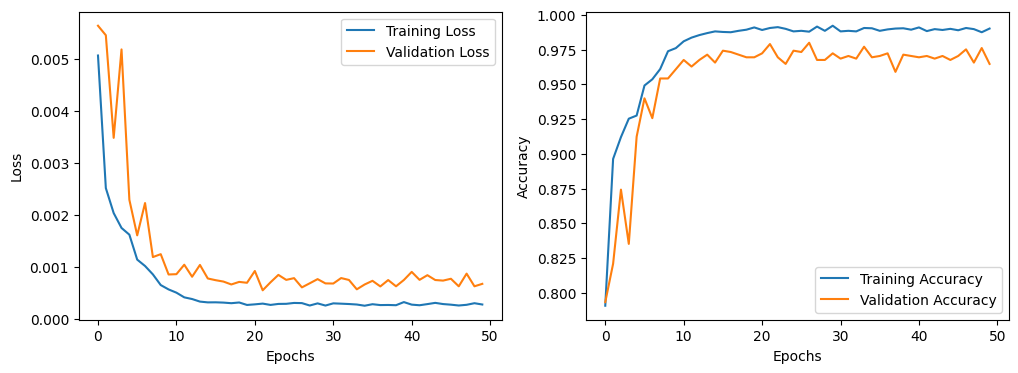

Saving resnet18_training_history.png
saved


<Figure size 640x480 with 0 Axes>

In [ ]:
# Model training routine 
if retrain:
    # Train the model
    model_ft = classifier.train_model(model_name, model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=num_epochs)
elif load_model:
    # Load weights
    checkpoint = torch.load(load_model)
    model_name = checkpoint['model_name']
    num_classes = checkpoint['num_classes']
    model_state_dict = checkpoint['state_dict']
    class_labels = checkpoint['class_labels']
    model_ft.load_state_dict(model_state_dict)
else:
    print("No model found")

## save weights

In [16]:
classifier.save_model(f'{model_name}', model_name, model_ft.state_dict(), dataset.get_classes_names())

model saved


# Evaluation

**F1 Score for Multiclass Classification:**

The F1 Score is a versatile metric that extends to multiclass classification tasks, providing a single value that balances precision and recall for each class. It is calculated using the following formula:

$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- **Precision:** Precision for a particular class measures the ability of the model to correctly identify instances of that class among all instances it identified as that class. It highlights the avoidance of false positives.

  $$
  \text{Precision} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Positives for the Class}}
  $$

- **Recall:** Recall for a particular class assesses the model's capacity to capture all instances of that class, minimizing false negatives.

  $$
  \text{Recall} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Negatives for the Class}}
  $$

- **F1 Score for Each Class:** In multiclass classification, an F1 Score is computed for each class. These individual F1 Scores consider the precision and recall specifically for that class.

- **Micro-Averaging and Macro-Averaging:** To obtain an overall F1 Score for the multiclass classification problem, you can use either micro-averaging (aggregating counts across all classes) or macro-averaging (calculating an unweighted average of F1 Scores for individual classes).

- **Balanced Performance:** The F1 Score serves as a valuable measure for balancing precision and recall across multiple classes, helping to find a trade-off between false positives and false negatives in a multiclass setting.

- **Range:** The F1 Score ranges from 0 to 1, with 1 indicating perfect precision and recall, and 0 indicating the worst performance across all classes.

In summary, the F1 Score is a versatile metric that can be applied to multiclass classification problems. It provides insights into the model's ability to balance precision and recall for each class while offering an overall assessment of performance across all classes.


**Recall (Sensitivity or True Positive Rate):**

- Measures the proportion of relevant items for a specific class that were correctly identified by a model or system.
- Answers: `Of all relevant items of this class, how many were correctly identified?`
- Formula:
$$
\text{Recall} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Negatives for the Class}}
$$
- High Recall captures most relevant items for a specific class but may lead to more false positives for that class.

**Precision:**

- Measures the proportion of items correctly identified as relevant for a specific class out of all items marked as relevant for that class by a model or system.
- Answers: `Of items marked as relevant for this class, how many are truly relevant for this class?`
- Formula:
$$
\text{Precision} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Positives for the Class}}
$$
- High Precision correctly identifies relevant items for a specific class but may miss some relevant items for that class, which can lead to lower Recall for that class.

**F1 Score:**

- The F1 Score is a comprehensive metric for multiclass classification that balances both Precision and Recall. It provides a single value that represents the harmonic mean of Precision and Recall for each class.
- Formula:
$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- The F1 Score for each class considers the Precision and Recall specifically for that class and helps in assessing the balance between false positives and false negatives across multiple classes.

This modified explanation includes information about Recall, Precision, and the F1 Score, along with LaTeX formulas, within the context of multiclass classification.


**Confusion Matrix for Multiclass:**

- The Confusion Matrix assesses multiclass classification model performance.
- It visualizes true positives, true negatives, false positives, and false negatives for each class.
- The matrix helps in understanding where the model makes correct and incorrect predictions for each class.

**Breakdown:**

1. **Rows and Columns:** Rows represent actual classes, columns represent predicted classes.

2. **Diagonal Elements:** Diagonal numbers are true positives (correctly classified).

3. **Off-Diagonal Elements:** Values outside the diagonal show incorrect classifications.

   -  In the `X` row and `Y` column, `N` instances were misclassified as `Y`.

4. **Interpreting Errors:** The Confusion Matrix reveals classes that tend to be confused with one another. For example, if in cell `[i,j]`, the model is prone to confusing `Class i` with `Class j`.




Evaluation Progress: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Evaluation Loss: 0.0645
Evaluation Accuracy: 98.10


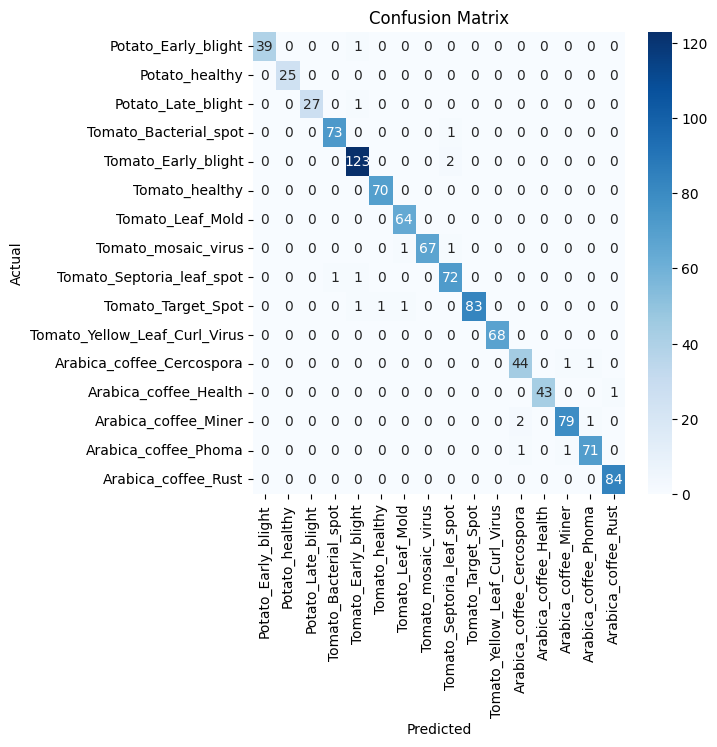

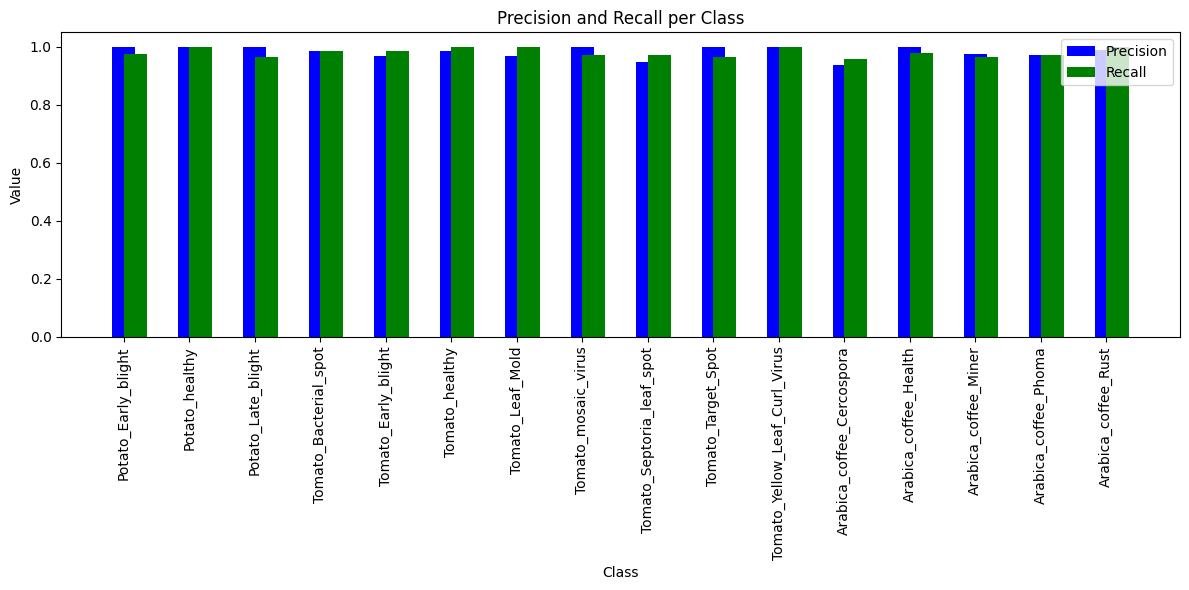

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                            Class  Precision    Recall
0             Potato_Early_blight   1.000000  0.975000
1                  Potato_healthy   1.000000  1.000000
2              Potato_Late_blight   1.000000  0.964286
3           Tomato_Bacterial_spot   0.986486  0.986486
4             Tomato_Early_blight   0.968504  0.984000
5                  Tomato_healthy   0.985915  1.000000
6                Tomato_Leaf_Mold   0.969697  1.000000
7             Tomato_mosaic_virus   1.000000  0.971014
8       Tomato_Septoria_leaf_spot   0.947368  0.972973
9              Tomato_Target_Spot   1.000000  0.965116
10  Tomato_Yellow_Leaf_Curl_Virus   1.000000  1.000000
11      Arabica_coffee_Cercospora   0.936170  0.956522
12          Arabica_coffee_Health   1.000000  0.977273
13           Arabica_coffee_Miner   0.975309  0.963415
14           Arabica_coffee_Phoma   0.972603  0.972603
15            Arabica_coffee_Rust   0.988235  1.000000


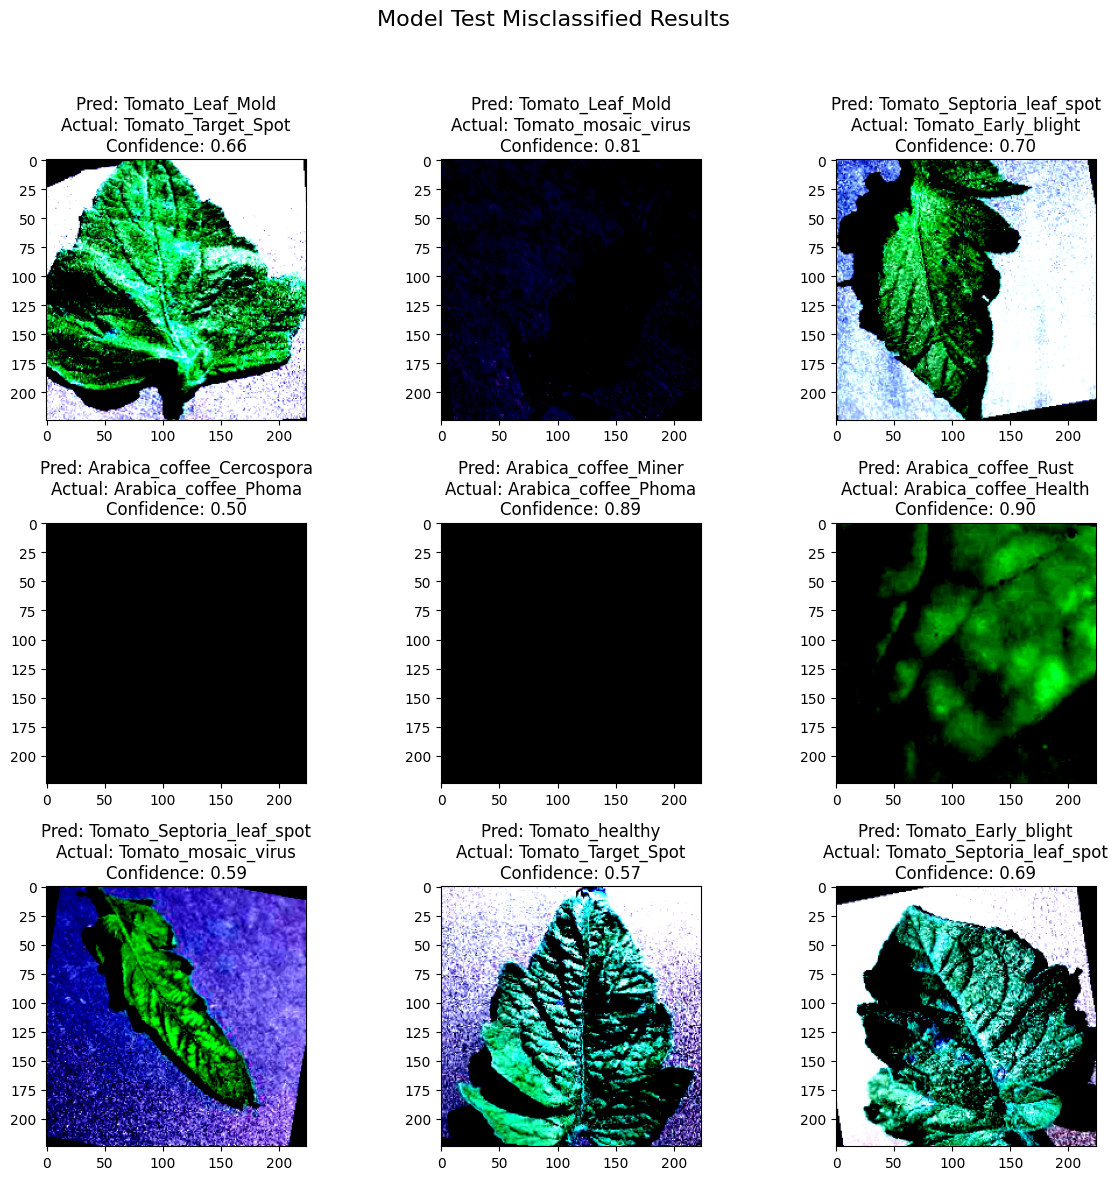

In [17]:
if eveluate:
    classifier.evaluate_model_with_limited_misclassified(model_ft, dataloaders['test'], criterion, device, list(dataset.get_classes_names().values()))

# Predict specific image

In [18]:
image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Downy_mildew', 'downymildew(2).jpeg')

In [19]:
classifier.predict_single_image(model_ft, image_path, device, dataset.get_classes_names())

Predicted Label: Tomato_Leaf_Mold, Confidence: 0.8743054270744324


('Tomato_Leaf_Mold', 0.8743054270744324)

# Continual Learning - Add new classes

In [20]:
num_epochs = 15

466 samples in the new dataset
Adding Sunflower_Downy_mildew with 16 to the dataset
Adding Sunflower_Gray_mold with 17 to the dataset
Adding Sunflower_Health_Leaf with 18 to the dataset
Adding Sunflower_Leaf_scars with 19 to the dataset
4 new classes added to the dataset
Epoch 0/14
----------


  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [02:27<00:00,  1.79s/it]
/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.0116 Acc: 0.8068


100%|██████████| 18/18 [00:31<00:00,  1.72s/it]


valid Loss: 0.0098 Acc: 0.8259

Epoch 1/14
----------


100%|██████████| 82/82 [02:30<00:00,  1.83s/it]


train Loss: 0.0079 Acc: 0.8495


100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


valid Loss: 0.0077 Acc: 0.8464

Epoch 2/14
----------


100%|██████████| 82/82 [02:30<00:00,  1.83s/it]


train Loss: 0.0060 Acc: 0.8868


100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


valid Loss: 0.0132 Acc: 0.8018

Epoch 3/14
----------


100%|██████████| 82/82 [02:36<00:00,  1.91s/it]


train Loss: 0.0059 Acc: 0.8832


100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


valid Loss: 0.0108 Acc: 0.8580

Epoch 4/14
----------


100%|██████████| 82/82 [02:32<00:00,  1.86s/it]


train Loss: 0.0041 Acc: 0.9130


100%|██████████| 18/18 [00:30<00:00,  1.71s/it]


valid Loss: 0.0050 Acc: 0.8920

Epoch 5/14
----------


100%|██████████| 82/82 [02:35<00:00,  1.90s/it]


train Loss: 0.0042 Acc: 0.9136


100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


valid Loss: 0.0066 Acc: 0.8893

Epoch 6/14
----------


100%|██████████| 82/82 [02:35<00:00,  1.89s/it]


train Loss: 0.0041 Acc: 0.9134


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


valid Loss: 0.0048 Acc: 0.9179

Epoch 7/14
----------


100%|██████████| 82/82 [02:38<00:00,  1.93s/it]


train Loss: 0.0033 Acc: 0.9325


100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


valid Loss: 0.0064 Acc: 0.8741

Epoch 8/14
----------


100%|██████████| 82/82 [02:36<00:00,  1.91s/it]


train Loss: 0.0031 Acc: 0.9382


100%|██████████| 18/18 [00:31<00:00,  1.77s/it]


valid Loss: 0.0038 Acc: 0.9179

Epoch 9/14
----------


100%|██████████| 82/82 [02:36<00:00,  1.91s/it]


train Loss: 0.0028 Acc: 0.9405


100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


valid Loss: 0.0051 Acc: 0.9321

Epoch 10/14
----------


100%|██████████| 82/82 [02:34<00:00,  1.89s/it]


train Loss: 0.0026 Acc: 0.9472


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


valid Loss: 0.0038 Acc: 0.9348

Epoch 11/14
----------


100%|██████████| 82/82 [02:33<00:00,  1.87s/it]


train Loss: 0.0019 Acc: 0.9598


100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


valid Loss: 0.0031 Acc: 0.9357

Epoch 12/14
----------


100%|██████████| 82/82 [02:33<00:00,  1.88s/it]


train Loss: 0.0025 Acc: 0.9512


100%|██████████| 18/18 [00:30<00:00,  1.70s/it]


valid Loss: 0.0046 Acc: 0.9187

Epoch 13/14
----------


100%|██████████| 82/82 [02:30<00:00,  1.84s/it]


train Loss: 0.0036 Acc: 0.9342


100%|██████████| 18/18 [00:29<00:00,  1.62s/it]


valid Loss: 0.0197 Acc: 0.7589

Epoch 14/14
----------


100%|██████████| 82/82 [02:31<00:00,  1.85s/it]


train Loss: 0.0039 Acc: 0.9285


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


valid Loss: 0.0043 Acc: 0.9089

Training complete in 46m 6s
Best val Acc: 0.935714


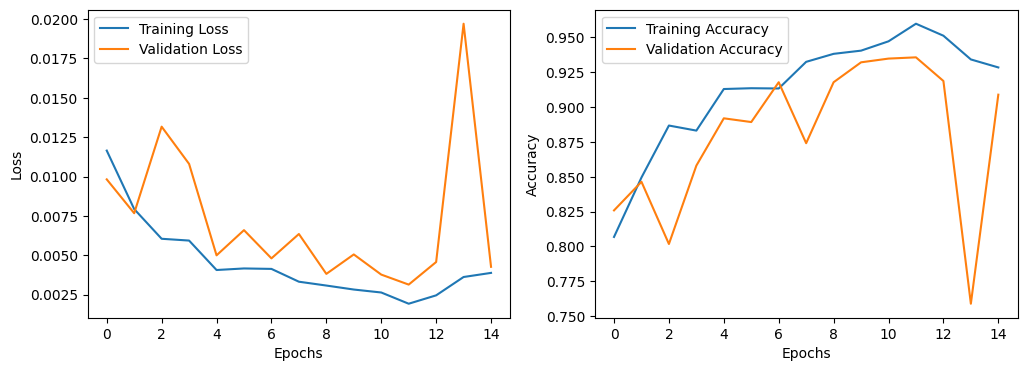

Saving resnet18_training_history.png
saved


<Figure size 640x480 with 0 Axes>

In [21]:
if add_classes_dir:
    new__model, new_dls, new_dataset, num_new_classes =classifier.add_new_classes_to_pretrained_model(model_name, dataset, model_ft, add_classes_dir, criterion, transform,
                                                                                                        scheduler=exp_lr_scheduler,
                                                                                                        learning_rate_first_layers=learning_rate_first_layers,
                                                                                                        learning_rate_final_layer=learning_rate_final_layer,
                                                                                                        num_epochs=num_epochs)


Evaluation Progress: 100%|██████████| 18/18 [00:27<00:00,  1.50s/it]


Evaluation Loss: 0.1985
Evaluation Accuracy: 94.12


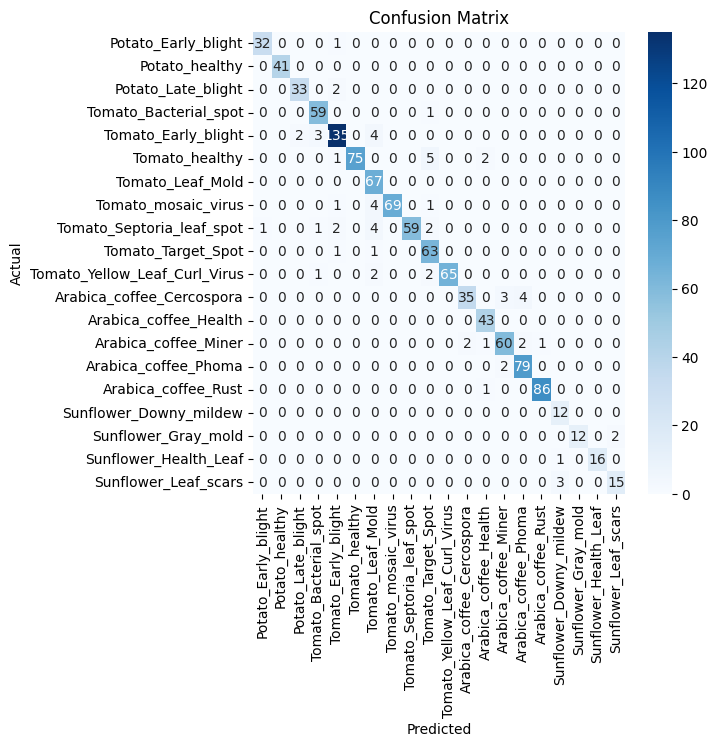

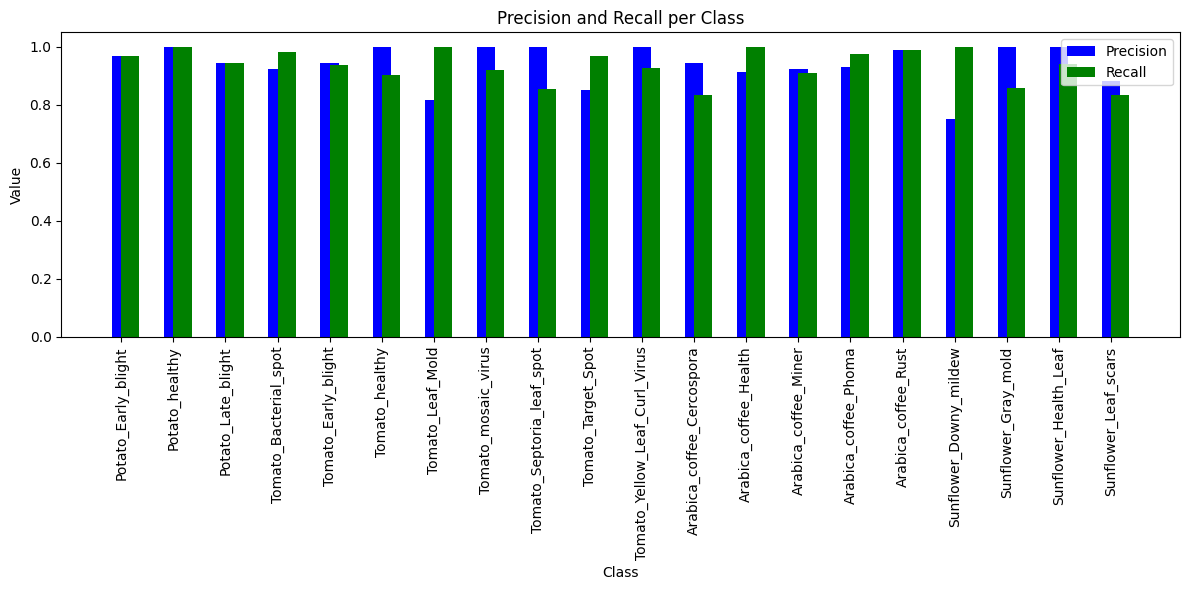

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                            Class  Precision    Recall
0             Potato_Early_blight   0.969697  0.969697
1                  Potato_healthy   1.000000  1.000000
2              Potato_Late_blight   0.942857  0.942857
3           Tomato_Bacterial_spot   0.921875  0.983333
4             Tomato_Early_blight   0.944056  0.937500
5                  Tomato_healthy   1.000000  0.903614
6                Tomato_Leaf_Mold   0.817073  1.000000
7             Tomato_mosaic_virus   1.000000  0.920000
8       Tomato_Septoria_leaf_spot   1.000000  0.855072
9              Tomato_Target_Spot   0.851351  0.969231
10  Tomato_Yellow_Leaf_Curl_Virus   1.000000  0.928571
11      Arabica_coffee_Cercospora   0.945946  0.833333
12          Arabica_coffee_Health   0.914894  1.000000
13           Arabica_coffee_Miner   0.923077  0.909091
14           Arabica_coffee_Phoma   0.929412  0.975309
15            Arabica_coffee_Rust   0.988506  0.988506
16         Sunflower_Downy_mildew   0.750000  1.000000
17        

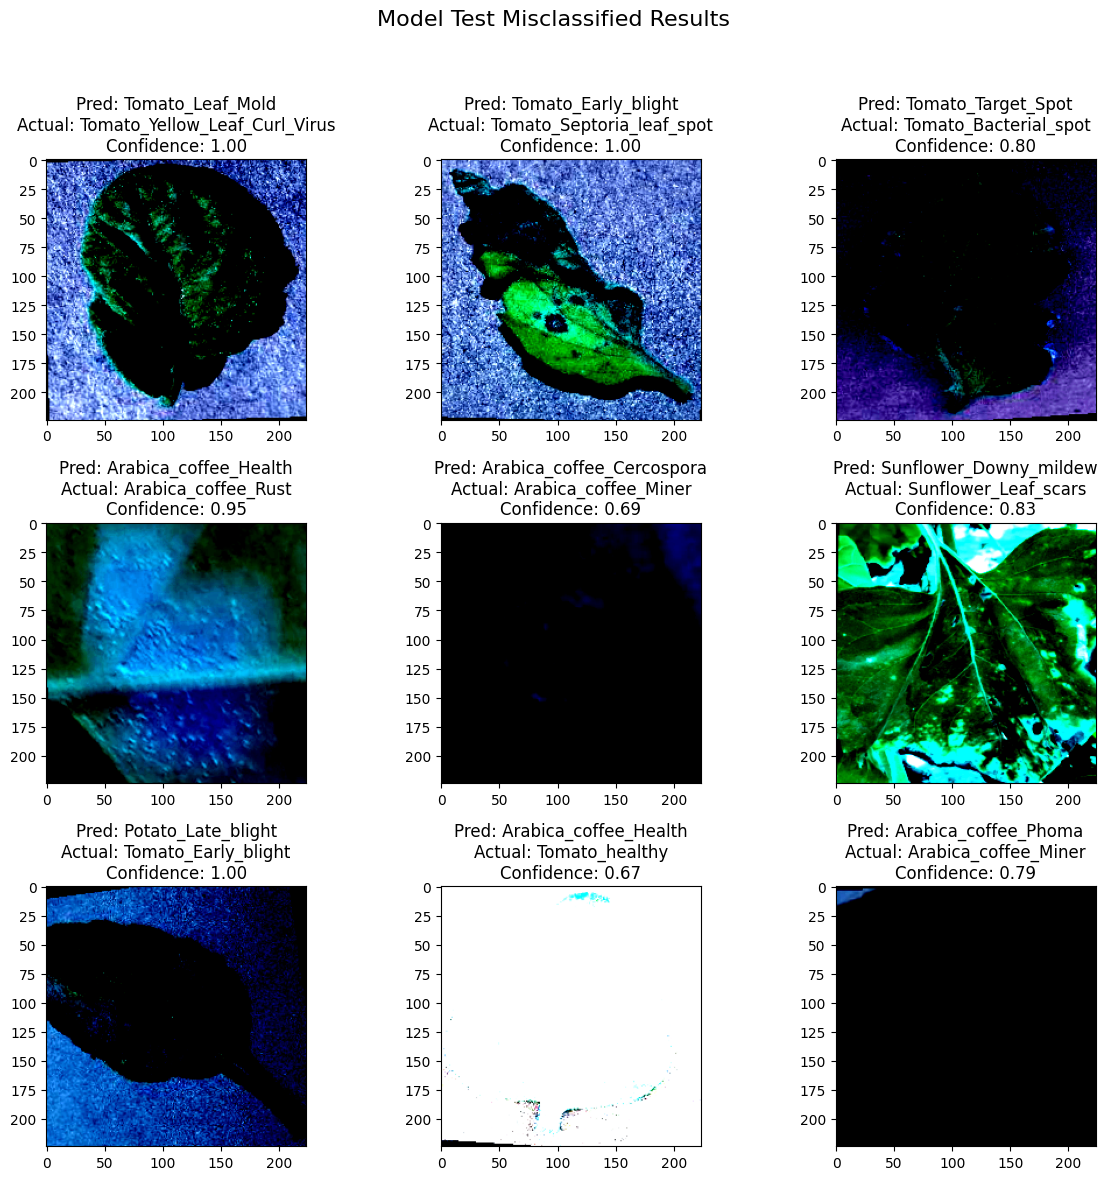

In [23]:
if eveluate and add_classes_dir:
    classifier.evaluate_model_with_limited_misclassified(new__model, new_dls['test'], criterion, device, list(new_dataset.get_classes_names().values()))


In [24]:
if add_classes_dir:
    classifier.save_model(f'{model_name}_new', model_name, new__model.state_dict(), new_dataset.get_classes_names())

model saved


In [32]:
image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Downy_mildew', 'downymildew(111).jpeg')
classifier.predict_single_image(new__model, image_path, device, dataset.get_classes_names())

Predicted Label: Sunflower_Health_Leaf, Confidence: 0.9126356244087219


('Sunflower_Health_Leaf', 0.9126356244087219)